In [103]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from  sklearn.ensemble import IsolationForest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt


In [80]:
data = pd.read_excel('data_ford_price.xlsx') 
data.tail()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
7012,22500,2015,3,6,23500,clean,automatic,rwd,full-size,32.680700,-117.169800,59.0
7013,5975,2005,2,8,0,clean,automatic,rwd,full-size,38.213303,-85.785762,50.0
7014,9999,2006,3,8,161514,clean,automatic,NaN,full-size,37.609783,-120.995406,59.0
7015,10900,2011,2,8,164000,clean,automatic,4wd,full-size,43.140600,-93.385000,47.0
7016,18000,2010,2,8,104000,clean,automatic,4wd,full-size,37.987200,-84.178900,50.0


## Полезные функции

In [81]:
def encode_cat_features(columns_to_change, X_train, X_test, y_train):
    one_hot_encoder = OneHotEncoder()
    X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()
    X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()

    columns = one_hot_encoder.get_feature_names_out(columns_to_change)
    
    X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
    X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)

    X_train = X_train.reset_index().drop(['index'], axis = 1)
    X_test = X_test.reset_index().drop(['index'], axis = 1)
    y_train = y_train.reset_index().drop(['index'], axis = 1)

    X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
    X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
    
    X_train_new = X_train_new.drop(columns=columns_to_change)
    X_test_new = X_test_new.drop(columns=columns_to_change)

    return X_train_new, X_test_new

    def visualise_prediction(model, targets, X_test_, title):
    preds = model.predict(X_test_)
    fig = plt.figure(figsize = (20, 10))
    plt.subplot(311)
    plt.plot(range(len(preds)), preds, range(len(targets)), targets)
    plt.xlim(0, len(targets))
    plt.ylim(0, max(max(preds), max(targets))*1.1)
    plt.legend(['predictions', 'real target'])
    plt.title(title)

    plt.subplot(312)
    plt.plot(range(len(preds)), preds, range(len(targets)), targets)
    plt.xlim(0, len(targets)*0.5)
    plt.ylim(0, max(preds.mean(), targets.mean())*1.5)
    plt.legend(['predictions', 'real target'])

    plt.subplot(313)
    plt.plot(range(len(preds)), preds, range(len(targets)), targets)
    plt.xlim(0, len(targets)*0.1)
    plt.ylim(0, max(preds.mean(), targets.mean())*1.5)
    plt.legend(['predictions', 'real target']);

In [82]:
y = data['price']
x = data.drop(columns='price')

## Обработаем пропуски

### Weather

In [83]:
# Скопируем данные в отдельную переменную
data = x.copy()
 
# В качестве тестовой выборки возьмем строки с пропусками в признаке weather
test_data = data[data['weather'].isnull()]
# И удалим эти строчки из таблицы
data.dropna(inplace=True)

# Определим целевой признак и факторы
y_train = data['weather']
X_train = data.drop(['size','weather','drive'], axis=1)
X_test = test_data.drop(['size','weather','drive'], axis=1)

# Создадим кодировщик
one_hot_encoder = OneHotEncoder()
categorial_cols = ['cylinders', 'title_status', 'transmission']

# Закодируем категориальные признаки (обучаем кодировщик только на тренировочной выборке)
X_train_onehot = one_hot_encoder.fit_transform(X_train[categorial_cols]).toarray()
X_test_onehot = one_hot_encoder.transform(X_test[categorial_cols]).toarray()

# Результаты преобразуем обратно в DataFrame для удобства
columns = one_hot_encoder.get_feature_names_out(categorial_cols)
X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)

# Сбросим индексы таблиц
X_train = X_train.reset_index().drop(['index'], axis = 1)
X_test = X_test.reset_index().drop(['index'], axis = 1)
y_train = y_train.reset_index().drop(['index'], axis = 1)

# Добавим результаты кодирования к исходным таблицам
X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)

# Удалим столбцы, которые уже были закодированы
X_train_new = X_train_new.drop(columns=categorial_cols)
X_test_new = X_test_new.drop(columns=categorial_cols)

# Создадим модель линейной регрессии и обучим ее на задачу предсказания пропусков
model = LinearRegression()
model.fit(X_train_new, y_train)

# Сделаем предсказание целевой переменной (пропущенных значений в признаке weather) 
y_pred = model.predict(X_test_new)
for i, ni in enumerate(test_data.index):
    x.loc[ni, 'weather'] = y_pred[i]

### size

In [84]:
data = x.copy()
 
test_data = data[data['size'].isnull()]
data.dropna(inplace=True)
 
y_train = data['size']
X_train = data.drop(['size', 'drive'], axis=1)
X_test = test_data.drop(['size','drive'], axis=1)
categorial_cols = ['cylinders', 'title_status', 'transmission']
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)

for i, ni in enumerate(test_data.index):
    x.loc[ni, 'size'] = y_pred[i]
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          7017 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


### drive

In [85]:
data = x.copy()
 
test_data = data[data['drive'].isnull()]
data.dropna(inplace=True)
 
y_train = data['drive']
X_train = data.drop(['drive'], axis=1)
X_test = test_data.drop(['drive'], axis=1)
categorial_cols = ['cylinders', 'title_status', 'transmission', 'size']
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)

for i, ni in enumerate(test_data.index):
    x.loc[ni, 'drive'] = y_pred[i]
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         7017 non-null   object 
 7   size          7017 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


In [86]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

## Отберем важные признаки

In [89]:
columns_selection = ['year','cylinders', 'odometer', 'lat', 'long', 'weather']

In [90]:

estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train[columns_selection], y_train)
 
selector.get_feature_names_out()

array(['year', 'cylinders', 'lat'], dtype=object)

In [93]:

selector = SelectKBest(f_regression, k=3)
selector.fit(X_train[columns_selection], y_train)
 
selector.get_feature_names_out()

array(['year', 'cylinders', 'odometer'], dtype=object)

In [100]:
features_rfe = ['year', 'cylinders', 'lat', 'odometer']
features_kbest = ['year', 'cylinders', 'odometer']
X_train_rfe, X_test_rfe = X_train[features_rfe], X_test[features_rfe]
X_train_kbest, X_test_kbest = X_train[features_kbest], X_test[features_kbest]

In [106]:
model_rfe = LinearRegression()
model_rfe.fit(X_train_rfe, y_train)
pred_rfe = model_rfe.predict(X_test_rfe)
mae = mean_absolute_error(y_test, pred_rfe)
r2 = r2_score(y_test, pred_rfe)
print(f'MAE RFE features: {mae:.3f}, R2 {r2:.3f}')

model_kbest = LinearRegression()
model_kbest.fit(X_train_kbest, y_train)
pred_kbest = model_kbest.predict(X_test_kbest)
mae = mean_absolute_error(y_test, pred_kbest)
r2 = r2_score(y_test, pred_kbest)
print(f'MAE Kbest features: {mae:.3f}, R2 {r2:.3f}')
 

MAE RFE features: 4877.445, R2 0.426
MAE Kbest features: 4906.797, R2 0.427


## Визуализация предсказаний

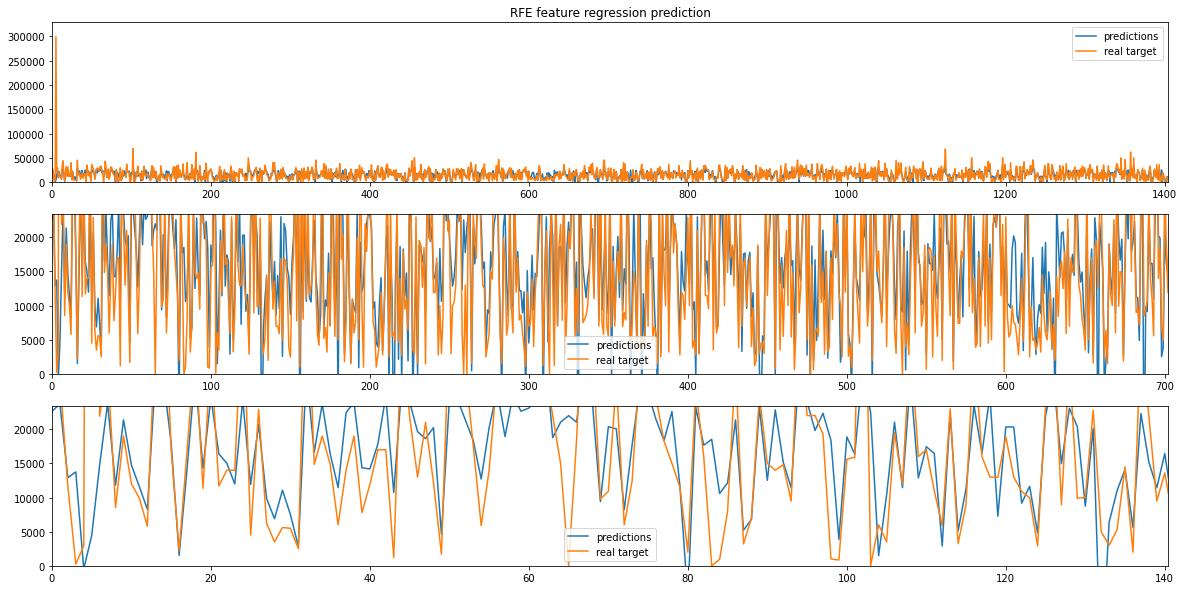

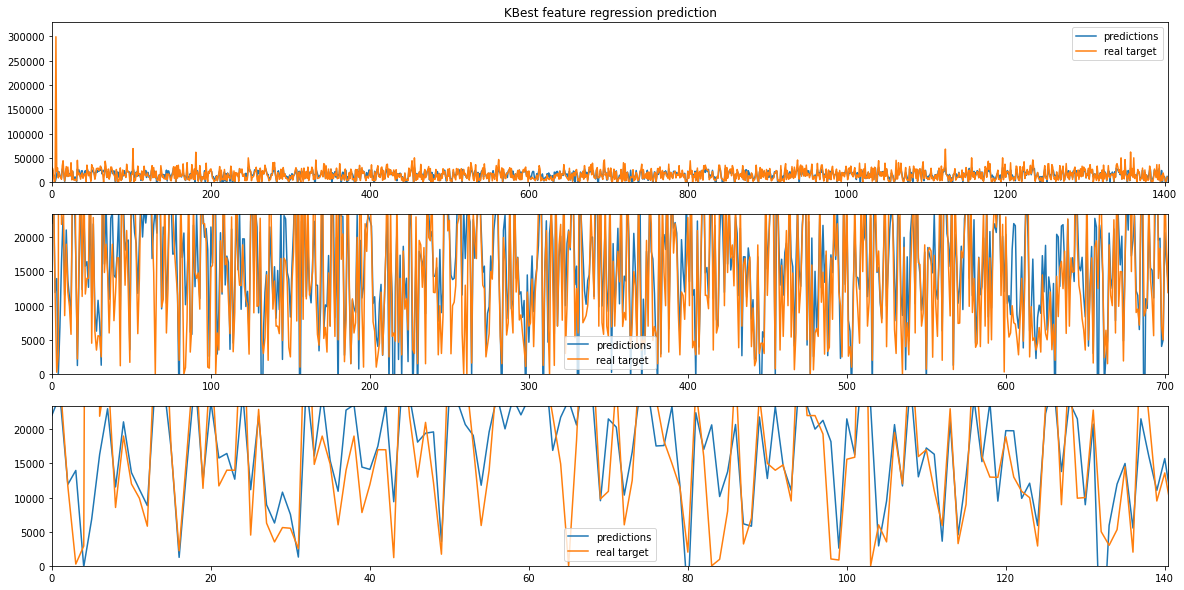

In [149]:
visualise_prediction(model_rfe, y_test, X_test_rfe, 'RFE feature regression prediction')
visualise_prediction(model_kbest, y_test, X_test_kbest, 'KBest feature regression prediction')

## Вывод

Вывод: колонки выбранны с помощью RFE дали лушее значение метрики МАЕ и незначительно меньшую метрику Р-квадрат

в целом у обоих моделей достаточно низкое значение метрики Р2 
не смотря на то что у одной из моделей метрика МАЕ ниже, не могу утверждать что одна из моделей лучше другой, так как обе достаточно плохо описывают закономерности в данных.

В данном задании мы исключили категориальные фичи, да и в целом три признака достаточно мало, чтобы построить хорошую модель
Я бы предположила что нужно выбрать более сложную модель и использовать больше признаков.
